In [1]:
!pip install -U ray[tune]

In [2]:
!pip install protobuf==3.20.*

In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [1]:
# libraries used in model construction
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.optim import lr_scheduler
from torchvision.models import ResNet18_Weights
from torchvision.models.mobilenetv3 import Weights
import copy # helps to make copies instead of references
from sklearn.model_selection import KFold

# libraries for performance measures visualisation
import time
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# libraries for data exploration
import cv2
import os
from PIL import Image
from pathlib import Path
import random

# libraries for hyperparameter tuning using rayTune
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# root file of dataset
path = r"D:\XMUM\Sem 6 September\AIT202 Deep Learning\Final_Project\Shoes"

### Step 1 Gather and arrange data

In [6]:
# dataset directory and arrangements
def list_files(startpath):
    space =  '    '
    branch = '│   '
    tee =    '├── '
    last =   '└── '
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = branch * level + tee
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent =  branch * (level+1) + space
        for f in files: 
            print('{}{}'.format(subindent+tee, files[0]))
            print('{}{}'.format(subindent+branch, '*'))
            print('{}{}'.format(subindent+last, files[-1]))
            break 
            
list_files(path)

├── Shoes/
│   ├── test/
│   │   ├── Adidas/
│   │   │       ├── Adidas_test_0.jpg
│   │   │       │   *
│   │   │       └── Adidas_test_9.jpg
│   │   ├── Nike/
│   │   │       ├── Nike_test_0.jpg
│   │   │       │   *
│   │   │       └── Nike_test_9.jpg
│   │   ├── Puma/
│   │   │       ├── Puma_test_0.jpg
│   │   │       │   *
│   │   │       └── Puma_test_9.jpg
│   ├── train/
│   │   ├── Adidas/
│   │   │       ├── Adidas_train_0.jpg
│   │   │       │   *
│   │   │       └── Adidas_train_99.jpg
│   │   ├── Nike/
│   │   │       ├── Nike_train_0.jpg
│   │   │       │   *
│   │   │       └── Nike_train_99.jpg
│   │   ├── Puma/
│   │   │       ├── Puma_train_0.jpg
│   │   │       │   *
│   │   │       └── Puma_train_99.jpg
│   ├── val/
│   │   ├── Adidas/
│   │   │       ├── Adidas_validate_0.jpg
│   │   │       │   *
│   │   │       └── Adidas_validate_9.jpg
│   │   ├── Nike/
│   │   │       ├── Nike_validate_0.jpg
│   │   │       │   *
│   │   │       └── Nike_validate_9.jpg
│   │   

### Step 2 : Explore and calculate normalization parameters of  our data

In [2]:
def normalization(image_size):
    # load all image and resize
    augs = transforms.Compose([transforms.Resize((image_size,image_size)),
                               transforms.ToTensor(),
                               transforms.Grayscale()])
    image_dataset = datasets.ImageFolder(path, transform=augs)
    image_loader = torch.utils.data.DataLoader(image_dataset, shuffle=False, num_workers=4, pin_memory=True) # for computation efficiency

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs, labels in tqdm(image_loader):
        psum    += inputs.sum(axis =      [0, 2, 3])
        psum_sq += (inputs**2).sum(axis = [0, 2, 3])

    # pixel count
    count = len(image_dataset) * image_size * image_size

    # mean, variance and standard deviation
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = np.array(total_mean)
    std = np.array(total_std)
    return mean, std

# perform normalization calculation
mean, std = normalization(224)
print(f"mean: {mean}, std: {std}")

  0%|          | 0/540 [00:00<?, ?it/s]

mean: [0.44826046 0.44826046 0.44826046], std: [0.25885904 0.25885904 0.25885904]


#### Be Aware that the figures of accuracy and loss might be deviated after each run

### Step 3 : experiment and find best model through hyperparameter tuning

In [3]:
# image file directories
train_file = "train"
test_file = "test"
val_file = "val"
train_dir = os.path.join(path, train_file)
test_dir = os.path.join(path, test_file)
val_dir = os.path.join(path, val_file)

# Hyper-parameters
num_epochs = 8    
batch_size = 4    
learning_rate = 0.0001   
momentum = 0.8           

# data augmentation
train_transform = transforms.Compose([transforms.RandomResizedCrop((224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop((224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])

# setting up dataloaders
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = batch_size, pin_memory=True)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = False, batch_size = batch_size, pin_memory=True)
val_data = datasets.ImageFolder(val_dir, transform = test_transform)
val_loader = torch.utils.data.DataLoader(val_data, shuffle = False, batch_size = batch_size, pin_memory=True)

classes = val_data.classes


# Model architecture 
class BaseCNN(nn.Module):
    def __init__(self, l1=128, l2=32):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)       # default stride=1
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.pool = nn.MaxPool2d(2, 2)         # (size, stride)
        self.fc1 = nn.Linear(64*53*53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, len(classes))
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # -> n, 1, 224, 224
        x = F.relu(self.conv1(x))    # -> n, 32, 220, 220
        x = self.pool(x)             # -> n, 32, 110, 110
        x = F.relu(self.conv2(x))    # -> n, 64, 106, 106
        x = self.pool(x)             # -> n, 64, 53, 53
        x = x.view(-1, 64*53*53)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))      # -> n, 128
        x = self.dropout(x)
        x = F.relu(self.fc2(x))      # -> n, 32
        x = self.fc3(x)              # -> n, 4
        return x
    
# Model configuration
model = BaseCNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay = 1e-4, lr=learning_rate, momentum=momentum)
optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
# train model
def train(optimizer):
    loss_history = []
    model.train()
    total_loss = 0.0
    corrects = 0
    for epoch in range(num_epochs):
        total_loss = 0.0
        corrects = 0
        loss_Sum_Per_Epoch = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(images)
            l = loss(outputs, labels)
            l.backward()
            optimizer.step()

            # epoch and loss tracking
            loss_Sum_Per_Epoch += l.item() 
        loss_history.append(loss_Sum_Per_Epoch/(i+1)) # used for the plotting
        
    return loss_history, model

# test or validate model
def test(model, data_loader):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(len(classes))]
        n_class_samples = [0 for i in range(len(classes))]
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index) 
            _, predicted = torch.max(outputs,1) # 1d outputs
            n_samples += labels.size(0) # 3
            n_correct += (predicted == labels).sum()
            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if(label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network:{acc} %')
        for i in range(len(classes)):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}:{acc} %')

Finished Training
Training time : 257.97229743003845 seconds
Accuracy of the network:54.62963104248047 %
Accuracy of Adidas:77.77777777777777 %
Accuracy of Nike:16.666666666666668 %
Accuracy of Puma:69.44444444444444 %


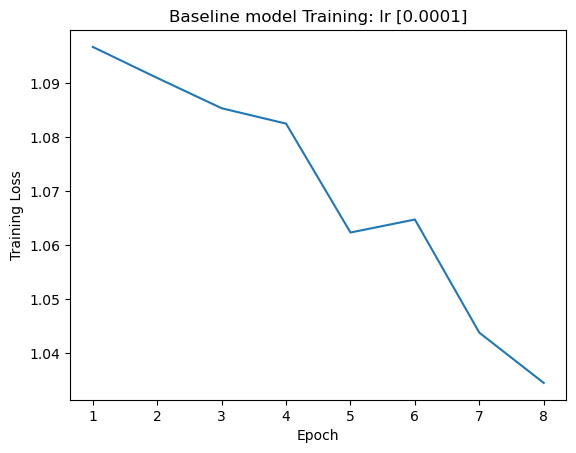

In [9]:
# using SGD optimizer with L2 regularisation (0.0001)
train_time_start = time.time()
loss_history_SGD, model_SGD = train(optimizer)

# plot loss graph
plt.plot([i for i in range(1, num_epochs+1)], loss_history_SGD)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f'Baseline model Training: lr [{learning_rate}]')

# measure time
train_time_end = time.time()
print('Finished Training')
print(f"Training time : {train_time_end - train_time_start} seconds")

# validate model
test(model_SGD, val_loader)

Finished Training
Training time : 258.31891989707947 seconds
Accuracy of the network:54.62963104248047 %
Accuracy of Adidas:86.11111111111111 %
Accuracy of Nike:8.333333333333334 %
Accuracy of Puma:69.44444444444444 %


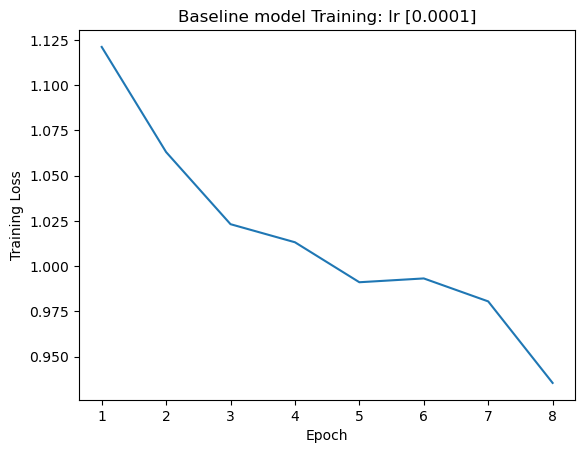

In [10]:
# using Adam optimizer without L2 regularisation
train_time_start = time.time()
loss_history_Adam, model_Adam = train(optimizer2)

# plot loss graph
plt.plot([i for i in range(1, num_epochs+1)], loss_history_Adam)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f'Baseline model Training: lr [{learning_rate}]') 

# measure time
train_time_end = time.time()
print('Finished Training')
print(f"Training time : {train_time_end - train_time_start} seconds")

# validate model
test(model_Adam, val_loader)

In [11]:
# save the 2 trained models above
save_path = f'modelSGD.pth'
torch.save(model_SGD.state_dict(), save_path)
save_path = f'modelADAM.pth'
torch.save(model_Adam.state_dict(), save_path)

In [5]:
# Hyperparameter tuning
def hp_train(config):
    net = BaseCNN(config["l1"], config["l2"])
    
    # device choice and parallelism
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    # model configuration
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

    # to restore a checkpoint, use session.get_checkpoint()
    # checkpoint is a global state for ray tune used to either interupt or resume a tuning session
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    # training model
    for epoch in range(8):  
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # loss tracking
            running_loss += loss.item()
            epoch_steps += 1

        # validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save((net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")
    
def test_best_model(best_result, data_loader):
    # obtain final hyperparameter tuned config and test it
    best_trained_model = BaseCNN(best_result.config["l1"], best_result.config["l2"])
    best_trained_model.to(device)
    
    # obtain checkpoint
    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)
    
    # testing the tuned model
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct/total
    return best_trained_model, acc

def hp_tuning(num_samples=10, max_num_epochs=8):
    # random search by default
    config = {"l1": tune.sample_from(lambda _: 2 ** np.random.randint(4, 10)),
              "l2": tune.sample_from(lambda _: 2 ** np.random.randint(4, 10)),
              "lr": tune.loguniform(1e-6, 1e-1)}
    
    scheduler = ASHAScheduler(max_t=max_num_epochs,
                              grace_period=1,
                              reduction_factor=2)
    
    tuner = tune.Tuner(tune.with_resources(tune.with_parameters(hp_train), resources={"cpu": 5, "gpu": 1}),
                       tune_config=tune.TuneConfig(metric="loss",
                                                   mode="min",
                                                   scheduler=scheduler,
                                                   num_samples=num_samples),
                       param_space=config)
    
    results = tuner.fit()
    best_result = results.get_best_result("loss", "min")
    
    hp_model, hp_acc = test_best_model(best_result, test_loader)
    return hp_model, hp_acc, results, best_result

hp_model, hp_acc, results, best_result = hp_tuning()
print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))
print("Best trial final validation accuracy: {}".format(best_result.metrics["accuracy"]))
print(f"Best accuracy obtained after hyperparameter tuning: {hp_acc}")

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
hp_train_3a63e_00000,0.333333,2022-12-17_14-29-25,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,8,1.09849,127.0.0.1,11732,True,391.366,49.396,391.366,1671258565,0,,8,3a63e_00000,0.00500298
hp_train_3a63e_00001,0.509259,2022-12-17_14-35-00,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,8,1.05657,127.0.0.1,11732,True,334.551,41.7921,334.551,1671258900,0,,8,3a63e_00001,0.00500298
hp_train_3a63e_00002,0.527778,2022-12-17_14-40-59,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,8,0.995124,127.0.0.1,11732,True,359.11,45.9394,359.11,1671259259,0,,8,3a63e_00002,0.00500298
hp_train_3a63e_00003,0.333333,2022-12-17_14-41-46,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,1,1.09872,127.0.0.1,11732,True,46.9855,46.9855,46.9855,1671259306,0,,1,3a63e_00003,0.00500298
hp_train_3a63e_00004,0.407407,2022-12-17_14-47-14,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,8,1.02211,127.0.0.1,11732,True,328.534,41.641,328.534,1671259634,0,,8,3a63e_00004,0.00500298
hp_train_3a63e_00005,0.407407,2022-12-17_14-53-43,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,8,0.942144,127.0.0.1,11732,True,388.829,49.4054,388.829,1671260023,0,,8,3a63e_00005,0.00500298
hp_train_3a63e_00006,0.324074,2022-12-17_14-54-27,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,1,1.09548,127.0.0.1,11732,True,43.3894,43.3894,43.3894,1671260067,0,,1,3a63e_00006,0.00500298
hp_train_3a63e_00007,0.472222,2022-12-17_14-57-16,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,4,1.05728,127.0.0.1,11732,True,169.308,42.413,169.308,1671260236,0,,4,3a63e_00007,0.00500298
hp_train_3a63e_00008,0.333333,2022-12-17_14-58-02,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,1,1.09869,127.0.0.1,11732,True,46.1072,46.1072,46.1072,1671260282,0,,1,3a63e_00008,0.00500298
hp_train_3a63e_00009,0.277778,2022-12-17_14-58-45,True,,06ba7f5a0fb54b068489dbe2ba3ac070,LAPTOP-QAMLO383,1,1.09829,127.0.0.1,11732,True,42.4309,42.4309,42.4309,1671260325,0,,1,3a63e_00009,0.00500298


(hp_train pid=11732) Finished Training
(hp_train pid=11732) Finished Training
(hp_train pid=11732) Finished Training
(hp_train pid=11732) Finished Training
(hp_train pid=11732) Finished Training


2022-12-17 14:58:45,163	INFO tune.py:762 -- Total run time: 2156.22 seconds (2156.07 seconds for the tuning loop).


Best trial config: {'l1': 512, 'l2': 16, 'lr': 0.00021684096828290364}
Best trial final validation loss: 0.9421440947938848
Best trial final validation accuracy: 0.4074074074074074
Best accuracy obtained after hyperparameter tuning: 0.5648148148148148


### Step 4 : Apply transfer learning with pretrained models

In [3]:
# define data loaders for below train func
dataloader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data), 'test': test_data}

In [4]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('----------------')
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            total_loss = 0.0
            corrects = 0
            # Iterate over data.
            for (inputs, labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # ResNet, AlexNet, VGGNet
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1) 
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                # statistics
                total_loss += loss.item()
                corrects += (preds == labels).sum() #torch.sum(preds == labels.data
            
            if phase == 'train':
                scheduler.step()
                pass
            epoch_average_loss = total_loss /(dataset_sizes[phase]/batch_size)
            epoch_acc = corrects / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_average_loss:.4f} Acc:{epoch_acc:.4f}')
            # copy the model when it achieves best val acc
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [19]:
# AlexNet
model = models.alexnet(pretrained=True)

# keep all hyperparameter fixed to judge model performance accurately
model_accuracy_table = [] # Accuracy table
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

num_ftr = model.classifier._modules['6'].in_features # 4096
model.classifier._modules['6'] = nn.Linear(num_ftr, len(classes)) # AlexNet fc layer
model = model.to(device)

time_start = time.time() 
model_4, acc= train_model(model, dataloader, criterion, optimizer, scheduler=step_lr_scheduler, num_epochs=num_epochs)
save_path = f'AlexNet_2.pth'
torch.save(model_4.state_dict(), save_path)
model_accuracy_table.append(acc)
time_end = time.time()
print(f"Training time on AlexNet: {time_end - time_start} seconds")

Epoch 1/8
----------------
train Loss: 1.0930 Acc:0.4506
val Loss: 1.0183 Acc:0.5093

Epoch 2/8
----------------
train Loss: 0.8487 Acc:0.5957
val Loss: 0.9562 Acc:0.5926

Epoch 3/8
----------------
train Loss: 0.7094 Acc:0.7130
val Loss: 0.7208 Acc:0.6574

Epoch 4/8
----------------
train Loss: 0.6899 Acc:0.7253
val Loss: 0.5874 Acc:0.7130

Epoch 5/8
----------------
train Loss: 0.6295 Acc:0.7284
val Loss: 0.7112 Acc:0.7130

Epoch 6/8
----------------
train Loss: 0.6078 Acc:0.7623
val Loss: 0.6919 Acc:0.7222

Epoch 7/8
----------------
train Loss: 0.4758 Acc:0.7963
val Loss: 0.5819 Acc:0.7963

Epoch 8/8
----------------
train Loss: 0.4620 Acc:0.8210
val Loss: 0.6113 Acc:0.7222

Best val Acc: 0.796296
Training time on AlexNet: 353.5930485725403 seconds


In [5]:
# VGG-19 (Very Deep Convolutional Networks)
model = models.vgg19(pretrained=True)

num_ftr = model.classifier._modules['6'].in_features # 4096
model.classifier._modules['6'] = nn.Linear(num_ftr, len(classes)) # vgg fc layer
model = model.to(device)

time_start = time.time() 
model_3, acc= train_model(model, dataloader, criterion, optimizer, scheduler=step_lr_scheduler, num_epochs=num_epochs)
save_path = f'VGG-19_2.pth'
torch.save(model_3.state_dict(), save_path)
model_accuracy_table.append(acc)
time_end = time.time()
print(f"Training time on VGG-19: {time_end - time_start} seconds")

C:\Users\langk\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\langk\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8
----------------
train Loss: 1.1417 Acc:0.3951
val Loss: 1.0899 Acc:0.4537

Epoch 2/8
----------------
train Loss: 1.1745 Acc:0.3704
val Loss: 1.0899 Acc:0.4537

Epoch 3/8
----------------
train Loss: 1.1773 Acc:0.3549
val Loss: 1.0899 Acc:0.4537

Epoch 4/8
----------------
train Loss: 1.1526 Acc:0.3519
val Loss: 1.0899 Acc:0.4537

Epoch 5/8
----------------
train Loss: 1.1577 Acc:0.3765
val Loss: 1.0899 Acc:0.4537

Epoch 6/8
----------------
train Loss: 1.1591 Acc:0.3673
val Loss: 1.0899 Acc:0.4537

Epoch 7/8
----------------
train Loss: 1.1466 Acc:0.3889
val Loss: 1.0899 Acc:0.4537

Epoch 8/8
----------------
train Loss: 1.1986 Acc:0.3426
val Loss: 1.0899 Acc:0.4537

Best val Acc: 0.453704
Training time on VGG-19: 387.62800431251526 seconds


In [6]:
# ResNet-34 (Residual neural network)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

time_start = time.time()
model_5, acc= train_model(model, dataloader, criterion, optimizer, scheduler=step_lr_scheduler, num_epochs=num_epochs)
save_path = f'ResNet-34_2.pth'
torch.save(model_5.state_dict(), save_path)
model_accuracy_table.append(acc)
time_end = time.time()
print(f"Training time on ResNet: {time_end - time_start} seconds")

C:\Users\langk\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8
----------------
train Loss: 1.1734 Acc:0.3519
val Loss: 1.1183 Acc:0.3241

Epoch 2/8
----------------
train Loss: 1.1298 Acc:0.3951
val Loss: 1.1315 Acc:0.3796

Epoch 3/8
----------------
train Loss: 1.1409 Acc:0.3642
val Loss: 1.1171 Acc:0.4074

Epoch 4/8
----------------
train Loss: 1.1740 Acc:0.3364
val Loss: 1.1225 Acc:0.3981

Epoch 5/8
----------------
train Loss: 1.1602 Acc:0.3580
val Loss: 1.1244 Acc:0.3148

Epoch 6/8
----------------
train Loss: 1.1459 Acc:0.3827
val Loss: 1.1119 Acc:0.3611

Epoch 7/8
----------------
train Loss: 1.1438 Acc:0.3673
val Loss: 1.1191 Acc:0.3796

Epoch 8/8
----------------
train Loss: 1.1326 Acc:0.4043
val Loss: 1.1122 Acc:0.3519

Best val Acc: 0.407407
Training time on ResNet: 345.2717378139496 seconds


In [8]:
# further train BaseCNN with Adam optimizer
model = BaseCNN(l1=512, l2=16) # tuned parameters
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00021684096828290364) # tuned parameters
model = model.to(device)
time_start = time.time()
model_6, acc= train_model(model, dataloader, criterion, optimizer, scheduler=step_lr_scheduler, num_epochs=24)
save_path = f'Final_Model_BaseCNN_Adam_2.pth'
torch.save(model_6.state_dict(), save_path)
model_accuracy_table.append(acc)
time_end = time.time()
print(f"Training time on BaseCNN with Adam optimzer: {time_end - time_start} seconds")

Epoch 1/24
----------------
train Loss: 1.1025 Acc:0.3920
val Loss: 1.0182 Acc:0.4815

Epoch 2/24
----------------
train Loss: 1.0611 Acc:0.4568
val Loss: 0.9811 Acc:0.5463

Epoch 3/24
----------------
train Loss: 1.0170 Acc:0.4753
val Loss: 0.9286 Acc:0.5833

Epoch 4/24
----------------
train Loss: 1.0271 Acc:0.4969
val Loss: 0.9470 Acc:0.5741

Epoch 5/24
----------------
train Loss: 0.9911 Acc:0.5494
val Loss: 0.9039 Acc:0.6111

Epoch 6/24
----------------
train Loss: 0.9652 Acc:0.5340
val Loss: 0.9273 Acc:0.5648

Epoch 7/24
----------------
train Loss: 0.9784 Acc:0.5525
val Loss: 0.9010 Acc:0.5648

Epoch 8/24
----------------
train Loss: 0.9595 Acc:0.5556
val Loss: 0.8739 Acc:0.6389

Epoch 9/24
----------------
train Loss: 0.9501 Acc:0.5370
val Loss: 0.9705 Acc:0.4259

Epoch 10/24
----------------
train Loss: 0.9117 Acc:0.5648
val Loss: 0.8510 Acc:0.6759

Epoch 11/24
----------------
train Loss: 0.9360 Acc:0.5679
val Loss: 0.8472 Acc:0.6389

Epoch 12/24
----------------
train Loss: 

In [11]:
#  further train on AlexNet
model = models.alexnet()
optimizer = torch.optim.SGD(model.parameters(), weight_decay = 0.01, lr=learning_rate, momentum=momentum) # fix overfitting

# if loading model from file
num_ftr = model.classifier._modules['6'].in_features # 4096
model.classifier._modules['6'] = nn.Linear(num_ftr, len(classes)) # AlexNet fc layer
model.load_state_dict(torch.load(f'AlexNet.pth'))
model.to(device)
model = model.to(device)

time_start = time.time() 
model_4, acc= train_model(model, dataloader, criterion, optimizer, scheduler=step_lr_scheduler, num_epochs=num_epochs)
save_path = f'AlexNet_2.pth'
torch.save(model_4.state_dict(), save_path)
model_accuracy_table[0] = acc
time_end = time.time()
print(f"Training time on AlexNet: {time_end - time_start} seconds")

Epoch 1/8
----------------
train Loss: 0.3706 Acc:0.8519
val Loss: 0.7891 Acc:0.7778

Epoch 2/8
----------------
train Loss: 0.3360 Acc:0.8642
val Loss: 0.7961 Acc:0.7870

Epoch 3/8
----------------
train Loss: 0.4638 Acc:0.8364
val Loss: 0.8051 Acc:0.7870

Epoch 4/8
----------------
train Loss: 0.2880 Acc:0.8981
val Loss: 0.8099 Acc:0.8056

Epoch 5/8
----------------
train Loss: 0.2436 Acc:0.9136
val Loss: 0.8841 Acc:0.7870

Epoch 6/8
----------------
train Loss: 0.3103 Acc:0.9043
val Loss: 0.8251 Acc:0.8241

Epoch 7/8
----------------
train Loss: 0.2311 Acc:0.9105
val Loss: 0.7967 Acc:0.8241

Epoch 8/8
----------------
train Loss: 0.2354 Acc:0.9043
val Loss: 0.8711 Acc:0.8333

Best val Acc: 0.833333
Training time on AlexNet: 339.82259464263916 seconds


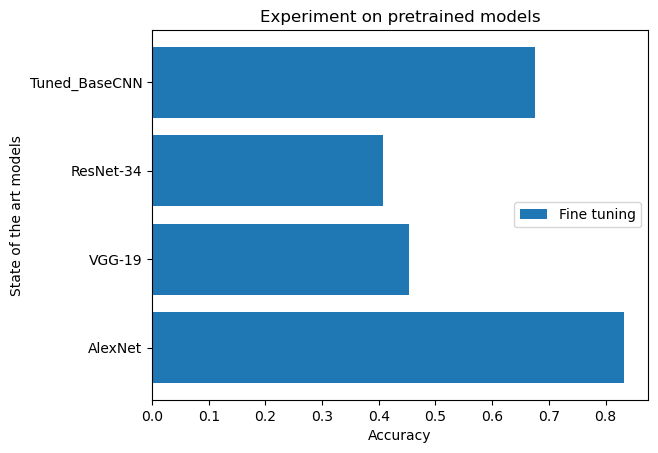

In [6]:
# move accuracies that are stored in GPU to CPU
accuracies = [i.cpu().numpy() for i in model_accuracy_table]

# plot bar chart of each pretrained model
model_name = ["AlexNet", "VGG-19", "ResNet-34", "Tuned_BaseCNN"]
plt.barh(model_name, accuracies, align='center', label="Fine tuning")
plt.legend()
plt.ylabel('State of the art models')
plt.xlabel('Accuracy')
plt.title('Experiment on pretrained models')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Making predictions:   0%|          | 0/27 [00:00<?, ?it/s]

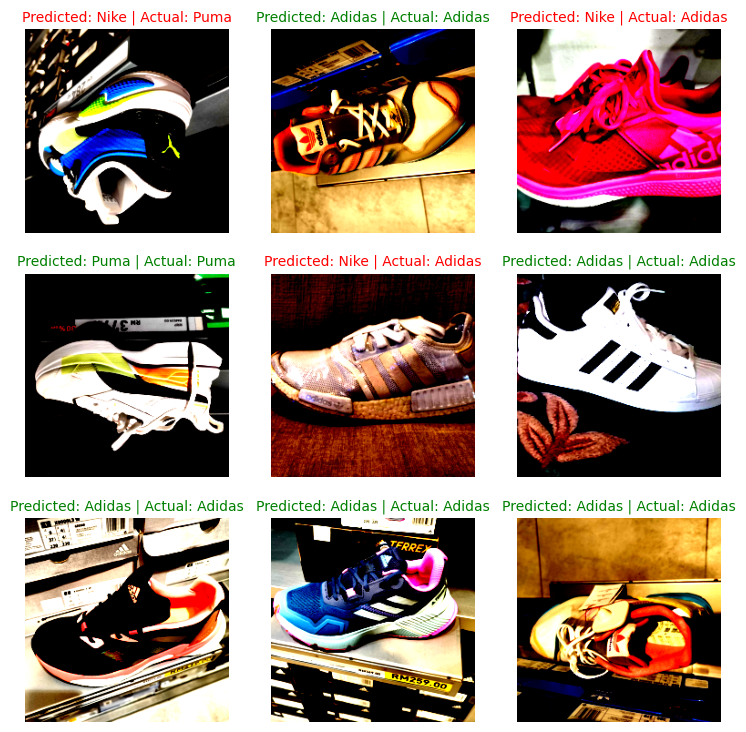

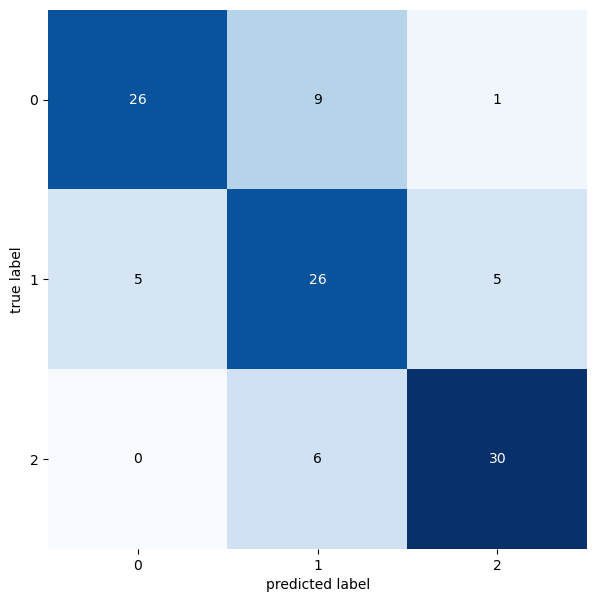

In [19]:
# final testing of best model
# make predictions on each single random image
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data: 
            sample = torch.unsqueeze(sample, dim=0).to(device)      # ddd an extra dimension and send sample to device
            pred_logit = model(sample)                              # foward pass
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)  # get each prediction probability
            pred_probs.append(pred_prob.cpu())                      # get from GPU push to CPU
            
    return torch.stack(pred_probs) # convert to tensors

def prob_n_conf(best_model):
    # get 9 random images from test set
    import random
    random.seed(42)
    test_samples = []
    test_labels = []
    for sample, label in random.sample(list(test_data), k=9):
        test_samples.append(sample)
        test_labels.append(label)

    # make predictions on test samples with best model(AlexNet)

    pred_probs= make_predictions(model=best_model, data=test_samples)
    pred_classes = pred_probs.argmax(dim=1)

    # plot predictions vs actuals
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(sample.permute(1, 2, 0) )
        pred_label = classes[pred_classes[i]]
        actual_label = classes[test_labels[i]] 
        title_text = f"Predicted: {pred_label} | Actual: {actual_label}"

        # check for equality and change title colour accordingly
        if pred_label == actual_label:
            plt.title(title_text, fontsize=10, c="g") # green text if correct
        else:
            plt.title(title_text, fontsize=10, c="r") # red text if wrong
        plt.axis(False);

    # perform one foward pass prediction
    y_preds = []
    y_actual = []
    best_model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_loader, desc="Making predictions"):
            y_actual.append(y)                                   # get actual labels
            X, y = X.to(device), y.to(device)
            y_logit = best_model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # predictions from logits -> prediction probabilities -> predictions labels
            y_preds.append(y_pred.cpu())

    # convert list to tensors
    y_pred_tensor = torch.cat(y_preds)   
    y_actual_tensor = torch.cat(y_actual)

    # define confusion matrix variables
    confmat = ConfusionMatrix(num_classes=len(classes))
    confmat_tensor = confmat(preds=y_pred_tensor, target=y_actual_tensor)

    # plot the confusion matrix
    fig, ax = plot_confusion_matrix(confmat_tensor.numpy(),
                                    classes, 
                                    figsize=(10, 7)
                                    )
    
prob_n_conf(model_4) # Alex overfitting but high acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Making predictions:   0%|          | 0/27 [00:00<?, ?it/s]

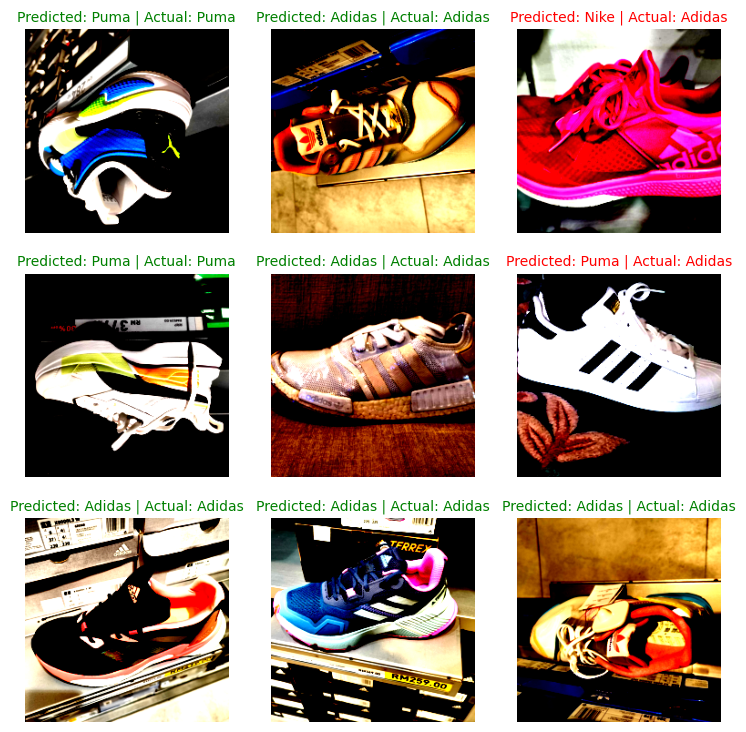

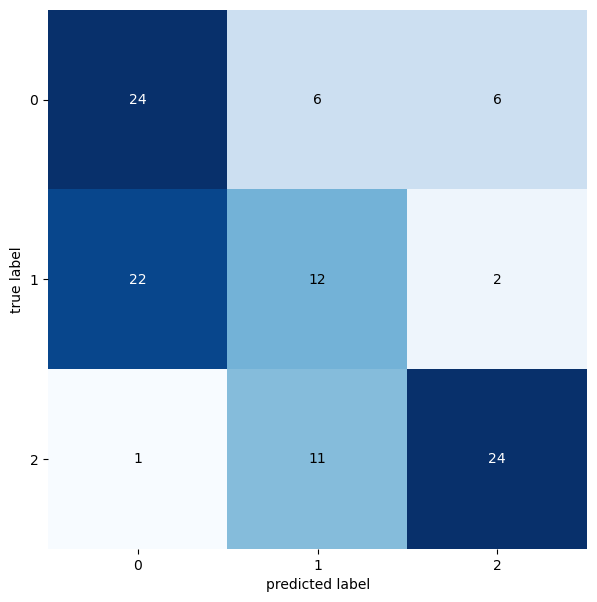

In [20]:
prob_n_conf(model_6) # BaseCNN no overfitting but low acc

In [1]:
model0 = BaseCNN(l1=256, l2=16).to(device)
model0.load_state_dict(torch.load("Final_Model_BaseCNN_Adam_2.pth"))

test(model0, test_loader)

NameError: name 'BaseCNN' is not defined